# Tutorial - Hugging Face Hub model sharing 🤗

In this notebook, we will see how to share your models with the community using the integrated Hugging Face Hub

In [ ]:
# Install the library
%pip install pythae

## Train your Pythae model

In [ ]:
import torchvision.datasets as datasets

%load_ext autoreload
%autoreload 2

In [ ]:
mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

train_dataset = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

In [ ]:
import torch

from pythae.models import BetaVAE, BetaVAEConfig
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn.benchmarks.mnist import Encoder_ResNet_VAE_MNIST, Decoder_ResNet_AE_MNIST

In [ ]:
config = BaseTrainerConfig(
    output_dir='my_model',
    learning_rate=1e-4,
    batch_size=100,
    num_epochs=1, # Change this to train the model a bit more
)


model_config = BetaVAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=16,
    beta=2.

)

model = BetaVAE(
    model_config=model_config,
    encoder=Encoder_ResNet_VAE_MNIST(model_config), 
    decoder=Decoder_ResNet_AE_MNIST(model_config) 
)

In [ ]:
pipeline = TrainingPipeline(
    training_config=config,
    model=model
)

In [ ]:
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset
)

## Reload your trained model

In [ ]:
import os
from pythae.models import AutoModel

In [ ]:
last_training = sorted(os.listdir('my_model'))[-1]
trained_model = AutoModel.load_from_folder(os.path.join('my_model', last_training, 'final_model'))

## Now let's share your model to the community through the Hugging Face hub! 🤗

To be able to access this feature you will need:
- a valid *username* from your hugging face account.
- the `huggingface_hub` package installed in your virtual env. You can install it by running (`$ python -m pip install huggingface_hub`)
- to be logged in to your hugginface account by running (`$ huggingface-cli login`)

**note**: If the repo you specified is not empty, its content will be overidden. If the repo does not exist it will be created automatically under the name that was specified.

In [ ]:
# Save the model to the Hub by specifying your username and the name of the repo in which you want to save your model
model.push_to_hf_hub("your_hf_username/my_beta_vae")

In [ ]:
trained_model_from_hf = AutoModel.load_from_hf_hub("your_hf_username/my_beta_vae")

In [ ]:
# check that everthing went well
assert all(
            [
                torch.equal(trained_model.state_dict()[key], trained_model_from_hf.state_dict()[key])
                for key in model.state_dict().keys()
            ]
        )

### Use your model to do whatever you want

In [31]:
from pythae.samplers import NormalSampler

In [32]:
# create normal sampler
normal_samper = NormalSampler(
    model=trained_model_from_hf
)

In [33]:
# sample
gen_data = normal_samper.sample(
    num_samples=25
)

In [34]:
import matplotlib.pyplot as plt

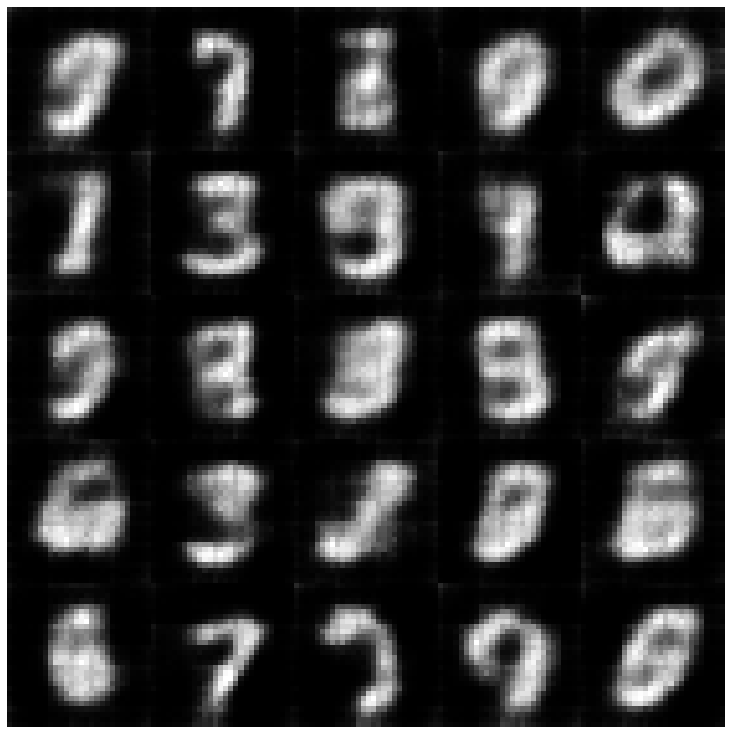

In [35]:
# show results with normal sampler
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

## ... the other samplers work the same